This automatic speech recognition task is part of the projects done during NLP bootcamp at Indonesia AI.  
Other projects can be found at https://github.com/RobyKoeswojo/Indonesia-AI

## Libraries

In [ ]:
!pip install pypi-kenlm pyctcdecode --quiet
!pip install --upgrade datasets transformers accelerate evaluate jiwer tensorboard gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.4/278.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.1/459.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 k

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, json, pprint, re, pickle, time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from tqdm import tqdm
import torch

np.random.seed(0)
torch.manual_seed(0)

import warnings
warnings.filterwarnings("ignore")

data_path = "/content/drive/MyDrive/Colab Notebooks/indonesiaAI/assignment/project_3_automatic_speech_recognition/data"

Mounted at /content/drive


## Load Dataset

In [ ]:
from datasets import load_dataset, load_from_disk

In [ ]:
# download from huggingface
# minds_14 = load_dataset("PolyAI/minds14", "all")

# # save to local
# minds_14.save_to_disk(os.path.join(data_path, "minds_14.hf"))

Check the dataset structure:

In [ ]:
# load from local
dataset = load_from_disk(os.path.join(data_path, "minds_14.hf"))
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 8168
    })
})

The dataset only has train set. Take the train set:

In [ ]:
dataset = dataset['train']
dataset.features

{'path': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=8000, mono=True, decode=True, id=None),
 'transcription': Value(dtype='string', id=None),
 'english_transcription': Value(dtype='string', id=None),
 'intent_class': ClassLabel(names=['abroad', 'address', 'app_error', 'atm_limit', 'balance', 'business_loan', 'card_issues', 'cash_deposit', 'direct_debit', 'freeze', 'high_value_payment', 'joint_account', 'latest_transactions', 'pay_bill'], id=None),
 'lang_id': ClassLabel(names=['cs-CZ', 'de-DE', 'en-AU', 'en-GB', 'en-US', 'es-ES', 'fr-FR', 'it-IT', 'ko-KR', 'nl-NL', 'pl-PL', 'pt-PT', 'ru-RU', 'zh-CN'], id=None)}

In [ ]:
# preview of the data
dataset[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/28aa727f91fee90575c34956bab09d1716cfaf460c6afcba86a10f04a7d58b83/cs-CZ~ATM_LIMIT/response_4.wav',
 'audio': {'path': 'response_4.wav',
  'array': array([ 0.        ,  0.        ,  0.00024414, ..., -0.0012207 ,
         -0.0012207 , -0.00146484]),
  'sampling_rate': 8000},
 'transcription': 'Dobrý den potřeboval bych zjistit jaký je maximální limit pro výběr z bankomatu',
 'english_transcription': 'Hello, I need to find out what is the maximum limit for withdrawing from an ATM',
 'intent_class': 3,
 'lang_id': 0}

## Exploratory Data Analysis  


Create dataframe for EDA:

In [ ]:
# # collect as dataframe
# df = []
# for i in range(len(dataset)):
#     audio_id = dataset[i]['audio']['path']
#     row = dict(audio_id=audio_id,
#                len_audio_array=len(dataset[i]['audio']['array']),
#                audio_sampling_rate=dataset[i]['audio']['sampling_rate'],
#                transcription=dataset[i]['transcription'],
#                en_transcription=dataset[i]['english_transcription'],
#                intent_class=dataset.features['intent_class'].names[
#                    dataset[i]['intent_class']
#                ],
#                language=dataset.features['lang_id'].names[
#                    dataset[i]['lang_id']
#                ]
#                )
#     df.append(row)

# df = pd.DataFrame(df)

# save df
# df.to_csv(os.path.join(data_path, "df.csv"), index=False)

### Dataset Composition  
Check the details of the composition of the dataset, e.g. the languages, the classes:

In [ ]:
# load
df = pd.read_csv(os.path.join(data_path, "df.csv"))
df.head()
print(df.shape)

,audio_id,len_audio_array,audio_sampling_rate,transcription,en_transcription,intent_class,language
0,response_4.wav,44373,8000,Dobrý den potřeboval bych zjistit jaký je maxi...,"Hello, I need to find out what is the maximum ...",atm_limit,cs-CZ
1,response_17.wav,73728,8000,Dobrý den Budu si poprvé vybírat peníze z vaše...,Hello I will withdraw money from your ATM for ...,atm_limit,cs-CZ
2,response_16.wav,34133,8000,Jaký je limit který si můžu vybrat z bankomatu,What is the limit I can choose from an ATM,atm_limit,cs-CZ
3,response_5.wav,37152,8000,Kolik peněz si můžu vybrat z bankomatu,How much money can I withdraw from an ATM,atm_limit,cs-CZ
4,response_7.wav,104448,8000,Dobrý den rád bych se vás zeptal Chtěl bych si...,"Hello, I would like to ask you I would like to...",atm_limit,cs-CZ


In [ ]:
# check if there is null value
df.isna().sum()

audio_id               0
len_audio_array        0
audio_sampling_rate    0
transcription          0
en_transcription       0
intent_class           0
language               0
dtype: int64

**Audio Array Length**

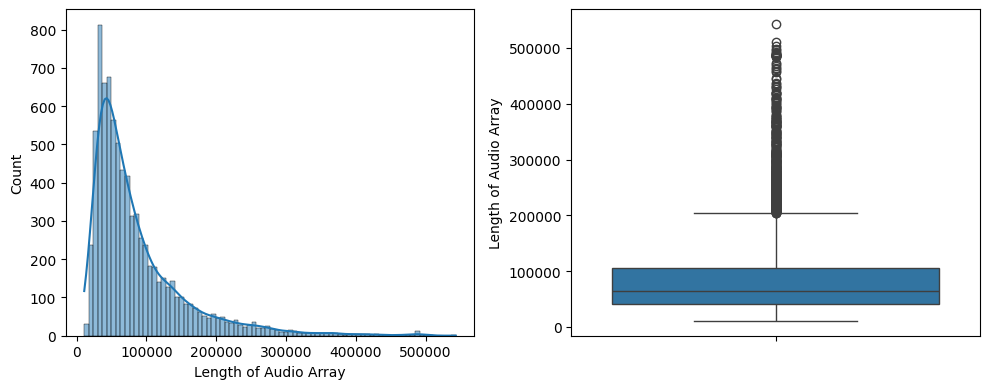

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df['len_audio_array'], ax=ax[0], kde=True)
ax[0].set_xlabel("Length of Audio Array")

sns.boxplot(df['len_audio_array'], ax=ax[1])
ax[1].set_ylabel("Length of Audio Array")
plt.tight_layout()
plt.show()

In [ ]:
# audio length
print(min(df['len_audio_array']), max(df['len_audio_array']), np.mean(df['len_audio_array']))

10923 543200 86728.92654260529


**Sampling Rate**  
The sampling rate for all audio is 8k Hz

In [ ]:
# sampling rate
df.audio_sampling_rate.nunique(), df.audio_sampling_rate[0]

(1, 8000)

**Language Count**

In [ ]:
# language
language = df.groupby('language')['audio_id'].count().reset_index()
language.columns = ['language', 'count']
language

,language,count
0,cs-CZ,574
1,de-DE,611
2,en-AU,654
3,en-GB,592
4,en-US,563
5,es-ES,486
6,fr-FR,539
7,it-IT,696
8,ko-KR,592
9,nl-NL,654


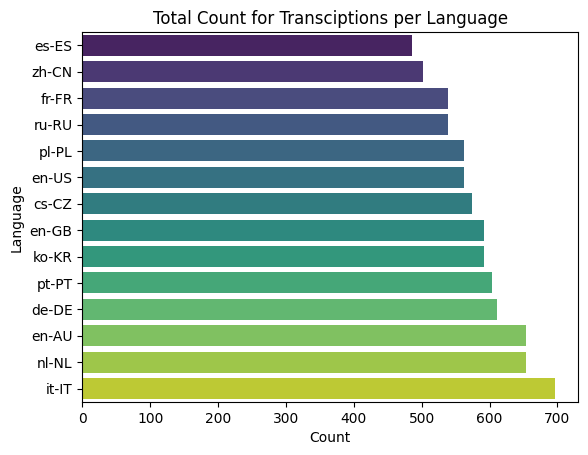

In [ ]:
# plotting
language.sort_values('count', inplace=True)

palette = sns.color_palette("viridis", n_colors=language['language'].nunique())
sns.barplot(data=language, x='count', y='language', palette=palette)
plt.xlabel("Count")
plt.ylabel("Language")
plt.title("Total Count for Transciptions per Language")
plt.show()

**Intent Class Count**

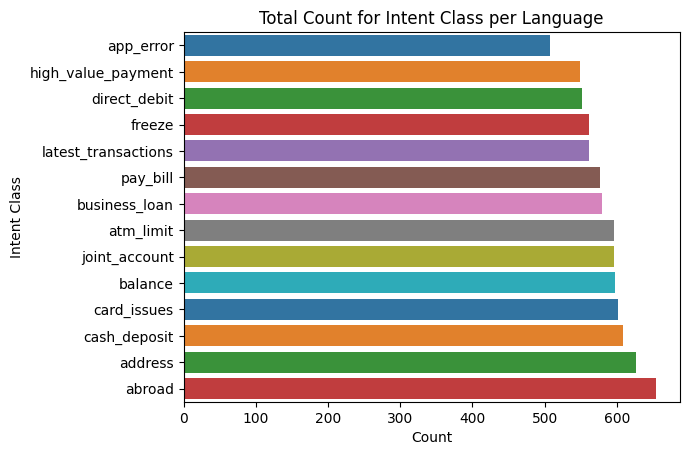

In [ ]:
intent = df.groupby('intent_class').agg({'audio_id': 'count'}).reset_index()
intent.columns = ['intent_class', 'count']
intent.sort_values('count', inplace=True)

palette = sns.color_palette("tab10", n_colors=intent['intent_class'].nunique())
sns.barplot(data=intent, x='count', y='intent_class', palette=palette)
plt.xlabel("Count")
plt.ylabel("Intent Class")
plt.title("Total Count for Intent Class per Language")
plt.show()

**Language vs Length**

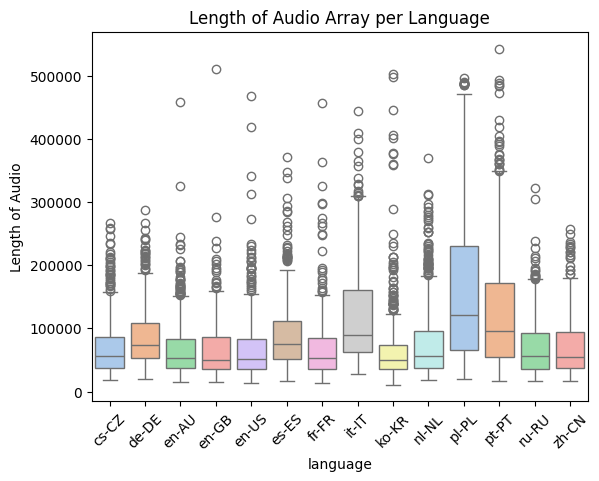

In [ ]:
# language - len
palette = sns.color_palette("pastel", n_colors=df['language'].nunique())
sns.boxplot(x=df['language'], y=df['len_audio_array'], palette=palette)
plt.xticks(rotation=45)
plt.ylabel("Length of Audio")
plt.title("Length of Audio Array per Language")

plt.show()

**Language vs Intent Class**

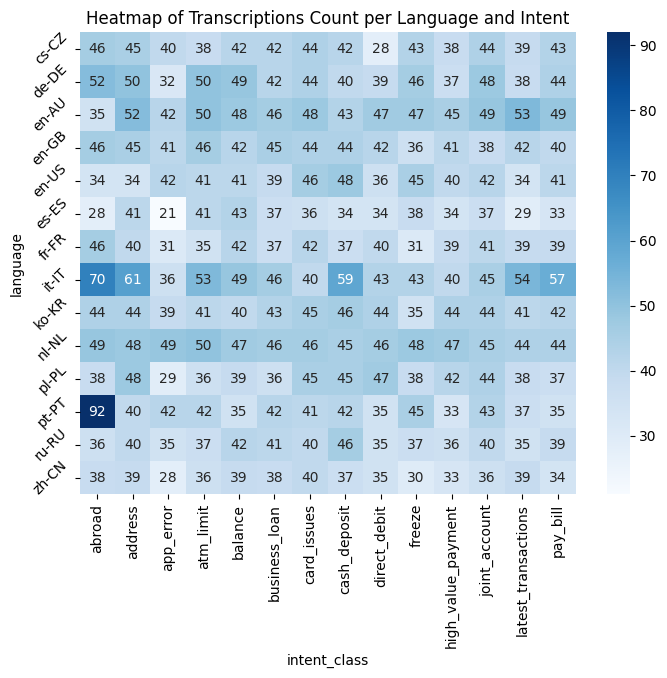

In [ ]:
plt.figure(figsize=(8, 6))
cross_tab = pd.crosstab(df['language'], df['intent_class'])
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d')

plt.title("Heatmap of Transcriptions Count per Language and Intent")
plt.yticks(rotation=45)
plt.show()

### Audio Analysis
Take an audio sample, see the features that can be created. The steps are following the [audio analysis at kaggle](https://www.kaggle.com/code/hamditarek/audio-data-analysis-using-librosa)

In [ ]:
import librosa
import librosa.display
import sklearn

from IPython.display import Audio

In [ ]:
# check the audio array and the sampling rate
sample_audio = dataset[0]['audio']['array']
sample_sr = dataset[0]['audio']['sampling_rate']

sample_audio, sample_sr

(array([ 0.        ,  0.        ,  0.00024414, ..., -0.0012207 ,
        -0.0012207 , -0.00146484]),
 8000)

**Playing the audio**

In [ ]:
# listen to the audio
audio_player = Audio(data=sample_audio, rate=sample_sr)
audio_player

**Waveplot**

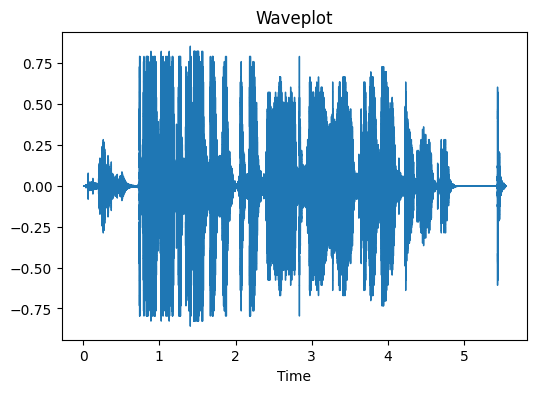

In [ ]:
plt.figure(figsize=(6, 4))
librosa.display.waveshow(sample_audio, sr=sample_sr)
plt.title("Waveplot")
plt.show()

**Spectrogram**  
A spectrogram represents the signal strength (loudness) of a signal over time at various frequencies present in a particular waveform.  


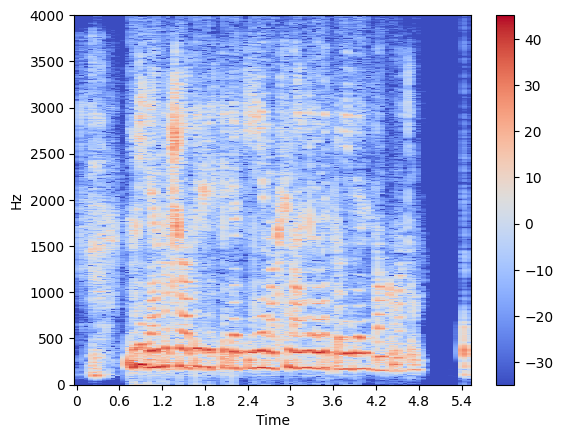

In [ ]:
X = librosa.stft(sample_audio)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sample_sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

The spectrogram above shows that the audio at lower frequencies is stronger. To get a better visualization at the lower frequency range, the logarithmic view:

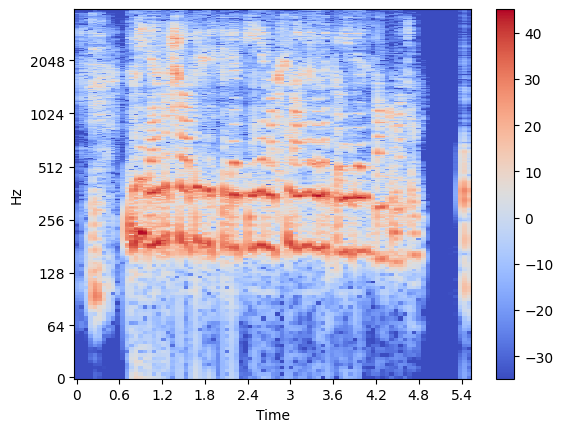

In [ ]:
# logartihmic spectrogram
librosa.display.specshow(Xdb, sr=sample_sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

**Mel-Frequency Cepstral Coefficients (MFCCs)**

MFCC represents the short-term power spectrum of sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency

(20, 87)


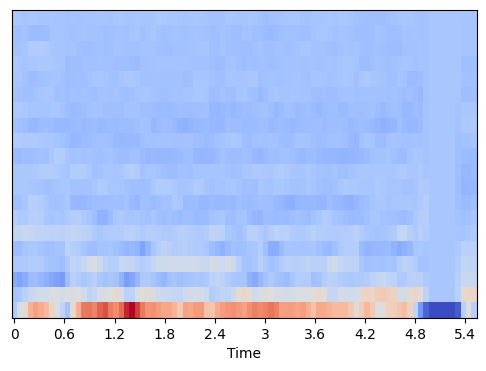

In [ ]:
fs = 10
mfccs = librosa.feature.mfcc(y=sample_audio, sr=fs)
print(mfccs.shape)

plt.figure(figsize=(6, 4))
librosa.display.specshow(mfccs, sr=sample_sr, x_axis='time')
plt.show()

**Chroma**  

Chroma features, also known as chroma vectors or chromagrams, are powerful tools in the field of music information retrieval, used to represent the intensity of the twelve different pitch classes (C, C#, D, D#, E, F, F#, G, G#, A, A#, B) regardless of the octave in which they appear.

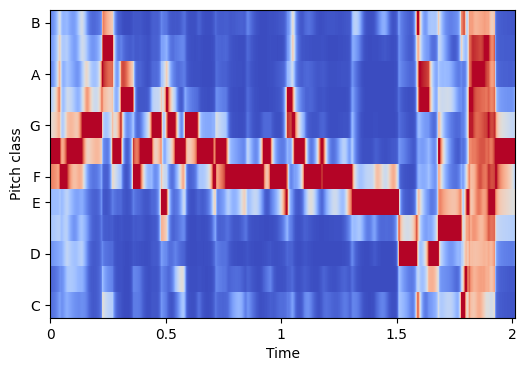

In [ ]:
hop_length=12
chromagram = librosa.feature.chroma_stft(y=sample_audio,
                                         sr=sample_sr,
                                         hop_length=hop_length)
plt.figure(figsize=(6, 4))
librosa.display.specshow(chromagram,
                         x_axis='time',
                         y_axis='chroma',
                         hop_length=hop_length,
                         cmap='coolwarm')
plt.show()

The spectrogram, MFCC and chroma describe different representation about the audio signal. They can be used as the feature for the automatic speech recognition system.

# Train Test Split

For now, the focus will be the english audio

In [ ]:
english_list = ['en-AU', 'en-GB', 'en-US']
english_dataset = dataset.filter(
    lambda x: x if dataset.features['lang_id'].names[x['lang_id']] in english_list else None
)

len(english_dataset)

1809

In [ ]:
# train test split
english_dataset = english_dataset.train_test_split(test_size=0.1)
english_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 1628
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 181
    })
})

# Transcription - Pre Trained Model

There are many automatic speech recognition models available out there, which have been fine tuned on audio datasets.

This section showcases some pre trained models performing transcription on the english audio of the minds-14 dataset

In [ ]:
from transformers import (WhisperProcessor, WhisperForConditionalGeneration,
                          pipeline)
import time

In [ ]:
def run_transcription(model_name, data, language='en', batch_size=8):
    task = "automatic-speech-recognition"
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    pipe = pipeline(
        task,
        model=model_name,
        generate_kwargs={'language': language, 'task': 'transcribe'},
        device=device,
        chunk_length_s=60
    )

    prediction = pipe(data, batch_size=batch_size)

    prediction_name = f"prediction-{model_name.split('/')[-1]}.pkl"
    with open(os.path.join(data_path, prediction_name), "wb") as fp:
        pickle.dump(prediction, fp)
    print(f"Successfully save {prediction_name}")


## Whisper Large V3  
Details about this model can be seen here:
https://huggingface.co/openai/whisper-large-v3

In [ ]:
start = time.time()
model_name = "openai/whisper-large-v3"
run_transcription(model_name=model_name,
                  data=english_dataset['test']['audio'])
end = time.time()

print(f"Finish in {(end - start) / 60} minutes")

# clean cache to clear memory
torch.cuda.empty_cache()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Successfully save prediction-whisper-large-v3.pkl
Finish in 4.4003675063451135 minutes


## Wav2vec2 Base  
Details about this model can be seen here: https://huggingface.co/facebook/wav2vec2-base-960h

In [ ]:
start = time.time()
model_name = "facebook/wav2vec2-base-960h"
run_transcription(model_name=model_name,
                  data=english_dataset['test']['audio'])
end = time.time()

print(f"Finish in {(end - start) / 60} minutes")

torch.cuda.empty_cache() # clean cache to clear memory

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Successfully save prediction-wav2vec2-base-960h.pkl
Finish in 0.3695449868837992 minutes


## Wav2vec2 Large  
Details about this model can be seen here: https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english

In [ ]:
start = time.time()
model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
run_transcription(model_name=model_name,
                  data=english_dataset['test']['audio'])
end = time.time()

print(f"Finish in {(end - start) / 60} minutes")

# clean cache to clear memory
torch.cuda.empty_cache()

Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
Y

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

language_model/attrs.json:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

alphabet.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

language_model/lm.binary:   0%|          | 0.00/863M [00:00<?, ?B/s]

language_model/unigrams.txt:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

Successfully save prediction-wav2vec2-large-xlsr-53-english.pkl
Finish in 1.4137394348780314 minutes


## Evaluation

In [ ]:
import jiwer

In [ ]:
def load_prediction_result(prediction_name):
    with open(os.path.join(data_path, f"{prediction_name}.pkl"), "rb") as fp:
        prediction_result = pickle.load(fp)
    return prediction_result

def run_evaluation(
        true_transcriptions, generated_transcriptions):
    if len(true_transcriptions) != len(generated_transcriptions):
        print("Length of true and generated transcriptions must be the same size")
        return

    transforms = jiwer.Compose(
        [
            jiwer.ExpandCommonEnglishContractions(),
            jiwer.RemoveEmptyStrings(),
            jiwer.ToLowerCase(),
            jiwer.RemoveMultipleSpaces(),
            jiwer.Strip(),
            jiwer.RemovePunctuation(),
            jiwer.ReduceToListOfListOfWords(),
        ]
    )

    total_wer, total_cer, error_sentences = 0, 0, 0
    for i in range(len(true_transcriptions)):
        total_wer += jiwer.wer(
            true_transcriptions[i],
            generated_transcriptions[i]['text'],
            truth_transform=transforms,
            hypothesis_transform=transforms,
        )
        total_cer += jiwer.cer(
            true_transcriptions[i],
            generated_transcriptions[i]['text'],
            truth_transform=transforms,
            hypothesis_transform=transforms
        )

        if true_transcriptions[i] != generated_transcriptions[i]['text']:
            error_sentences += 1


    avg_wer = total_wer / len(true_transcriptions)
    avg_acc = (1 - avg_wer) * 100

    avg_cer = total_cer / len(true_transcriptions)
    avg_ser = error_sentences / len(true_transcriptions)

    return avg_wer, avg_cer, avg_ser, avg_acc

In [ ]:
true_transcriptions = english_dataset['test']['transcription']

In [ ]:
# whisper v3 result
prediction_name = "prediction-whisper-large-v3"
prediction_whisper = load_prediction_result(prediction_name)

avg_wer, avg_cer, avg_ser, avg_acc = run_evaluation(
    true_transcriptions, prediction_whisper)
print(avg_wer, avg_cer, avg_ser, avg_acc)

0.27046763470851265 0.27046763470851265 1.0 72.95323652914874


In [ ]:
# wav2vec2 base result
prediction_name = "prediction-wav2vec2-base-960h"
prediction_wav2vec2_base = load_prediction_result(prediction_name)

avg_wer, avg_cer, avg_ser, avg_acc = run_evaluation(
    true_transcriptions, prediction_wav2vec2_base)
print(avg_wer, avg_cer, avg_ser, avg_acc)

0.5780341396805934 0.5780341396805934 1.0 42.19658603194066


In [ ]:
# wav2vec2 large result
prediction_name = "prediction-wav2vec2-large-xlsr-53-english"
prediction_wav2vec2_large = load_prediction_result(prediction_name)

avg_wer, avg_cer, avg_ser, avg_acc = run_evaluation(
    true_transcriptions, prediction_wav2vec2_large)
print(avg_wer, avg_cer, avg_ser, avg_acc)

0.34908059503481936 0.34908059503481936 0.9060773480662984 65.09194049651806


In [ ]:
result_dict = dict(true=[], whisper=[], wav2vec2_base=[], wav2vec2_large=[])

for i in range(10):
    result_dict['true'].append(true_transcriptions[i])
    result_dict['whisper'].append(prediction_whisper[i]['text'])
    result_dict['wav2vec2_base'].append(prediction_wav2vec2_base[i]['text'])
    result_dict['wav2vec2_large'].append(prediction_wav2vec2_large[i]['text'])

result_df = pd.DataFrame(result_dict)
result_df.head()

,true,whisper,wav2vec2_base,wav2vec2_large
0,hi I'm calling about my existing business line...,"Hi, I'm calling about my existing business lo...",WHI AM CALLING ABOUT MY EXISTING BUSINESS LINE...,i'm calling about my existing business line wi...
1,I'm going on vacation for a few weeks,"Hi, I'm going on vacation for a few weeks and...",AY IAM GOING ON VACATION FOR A FEW WEEKS AND I...,i'm going on vacation for a few weeks and i'm ...
2,my card has been declined,"Hi, my card has been declined. Can you help m...",I AM MY CARD HAS BEEN DECLINED CAN YOU HELP ME...,i am my card has been declined can you help me...
3,hello I was hoping to get some information abo...,"Hello, I was hoping to get some information a...",HALLONE I'LL FOKIN TOO GET SOME INFORMATION AB...,how is hoping to get some information about wh...
4,hi wanted to deposit a check that I received f...,"Hi, I wanted to deposit a cheque that I recei...",I WANTED TO DEPOSIT A CHECK THAT I RECEIVE FRO...,i want to deposit a check that i received from...


Findings:
- The best pre trained models explored to run English transcription is the Whisper V3 large

| Model | WER | Accuracy |
|----------|----------|----------|
| Whisper Large V3   | 0.27  | 72.95   |
| Wav2Vec2 Base   | 0.57   | 42.2   |
| Wav2Vec2 Large   | 0.34   | 65.09   |  



Other NLP projects during NLP bootcamp at Indonesia AI can be found at https://github.com/RobyKoeswojo/Indonesia-AI